In [6]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

In [7]:
pre_path = 'data/'
suffix = '_clustered.csv'

subreddits = list(glob.glob('data/*'))
subreddits = list(set([sub.split('\\')[1].split('_')[0] for sub in subreddits]))

n_subs =  len(subreddits)

dfs_clustered = {}
for sub in subreddits:
    dfs_clustered[sub] = pd.read_csv(pre_path + sub + suffix, index_col = 'comment_id')

Note about DBSCAN:  
Getting optimal values that present 60 clusters and only cover a small part of the observations does not fit well with what we are trying to investigate, which is some general tendencies in the data.  

Note about the amount of clusters for GMM:  
It probably makes a lot of sense that the 4 standard subreddits we are investigating have approximately the same amount of clusters.  

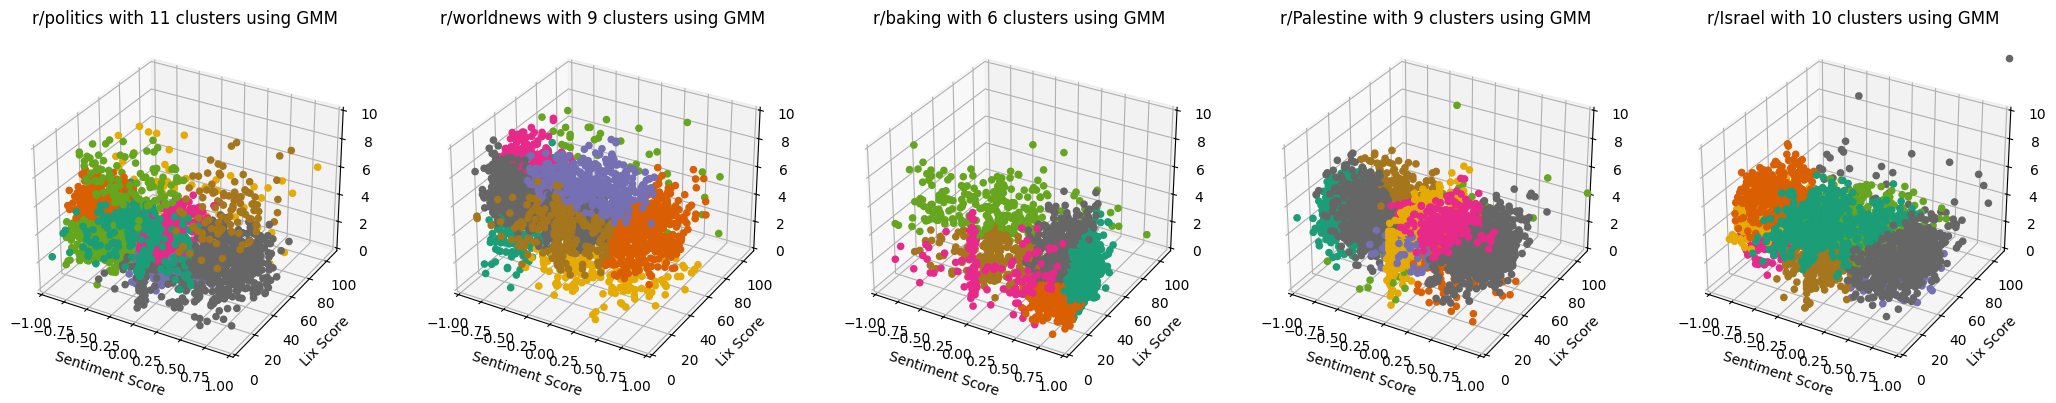

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=n_subs, figsize=(26, 5), subplot_kw={'projection': '3d'})

method = 'GMM' #Can also be 'DBSCAN'
cluster_type = f'{method}_cluster'
lix_lim = [0, 110]  # Range for Lix Score
sentiment_lim = [-1, 1]  # Range for Sentiment Score
log_upvotes_lim = [0, 10]  # Range for Log Upvotes

for i, (sub, df) in enumerate(dfs_clustered.items()):
    n_clusters = df[cluster_type].nunique()

    # Set color: grey for cluster -1, others will use a colormap
    colors = df[cluster_type].apply(lambda x: 'grey' if x == -1 else None)
    
    # Assign transparency: 50% for cluster -1, 100% (1.0) for others
    alphas = df[cluster_type].apply(lambda x: 0.1 if x == -1 else 1.0)

    # Handle valid colors for other clusters
    # Replace 'None' with colormap values for non -1 clusters
    cmap = plt.get_cmap('Dark2', n_clusters)
    cluster_colors = df[cluster_type].apply(lambda x: cmap(x) if x != -1 else 'grey')

    # Plot the 3D scatterplot
    scatter = axes[i].scatter(
        df['sentiment_score'], df['lix_score'], df['log_upvotes'],
        facecolors=cluster_colors, alpha=alphas
    )
    axes[i].set_title(f'r/{sub} with {n_clusters} clusters using {method}')
    axes[i].set_xlabel('Sentiment Score')
    axes[i].set_ylabel('Lix Score')
    # Set axis limits
    axes[i].set_xlim(sentiment_lim)
    axes[i].set_ylim(lix_lim)
    axes[i].set_zlim(log_upvotes_lim)

plt.show()


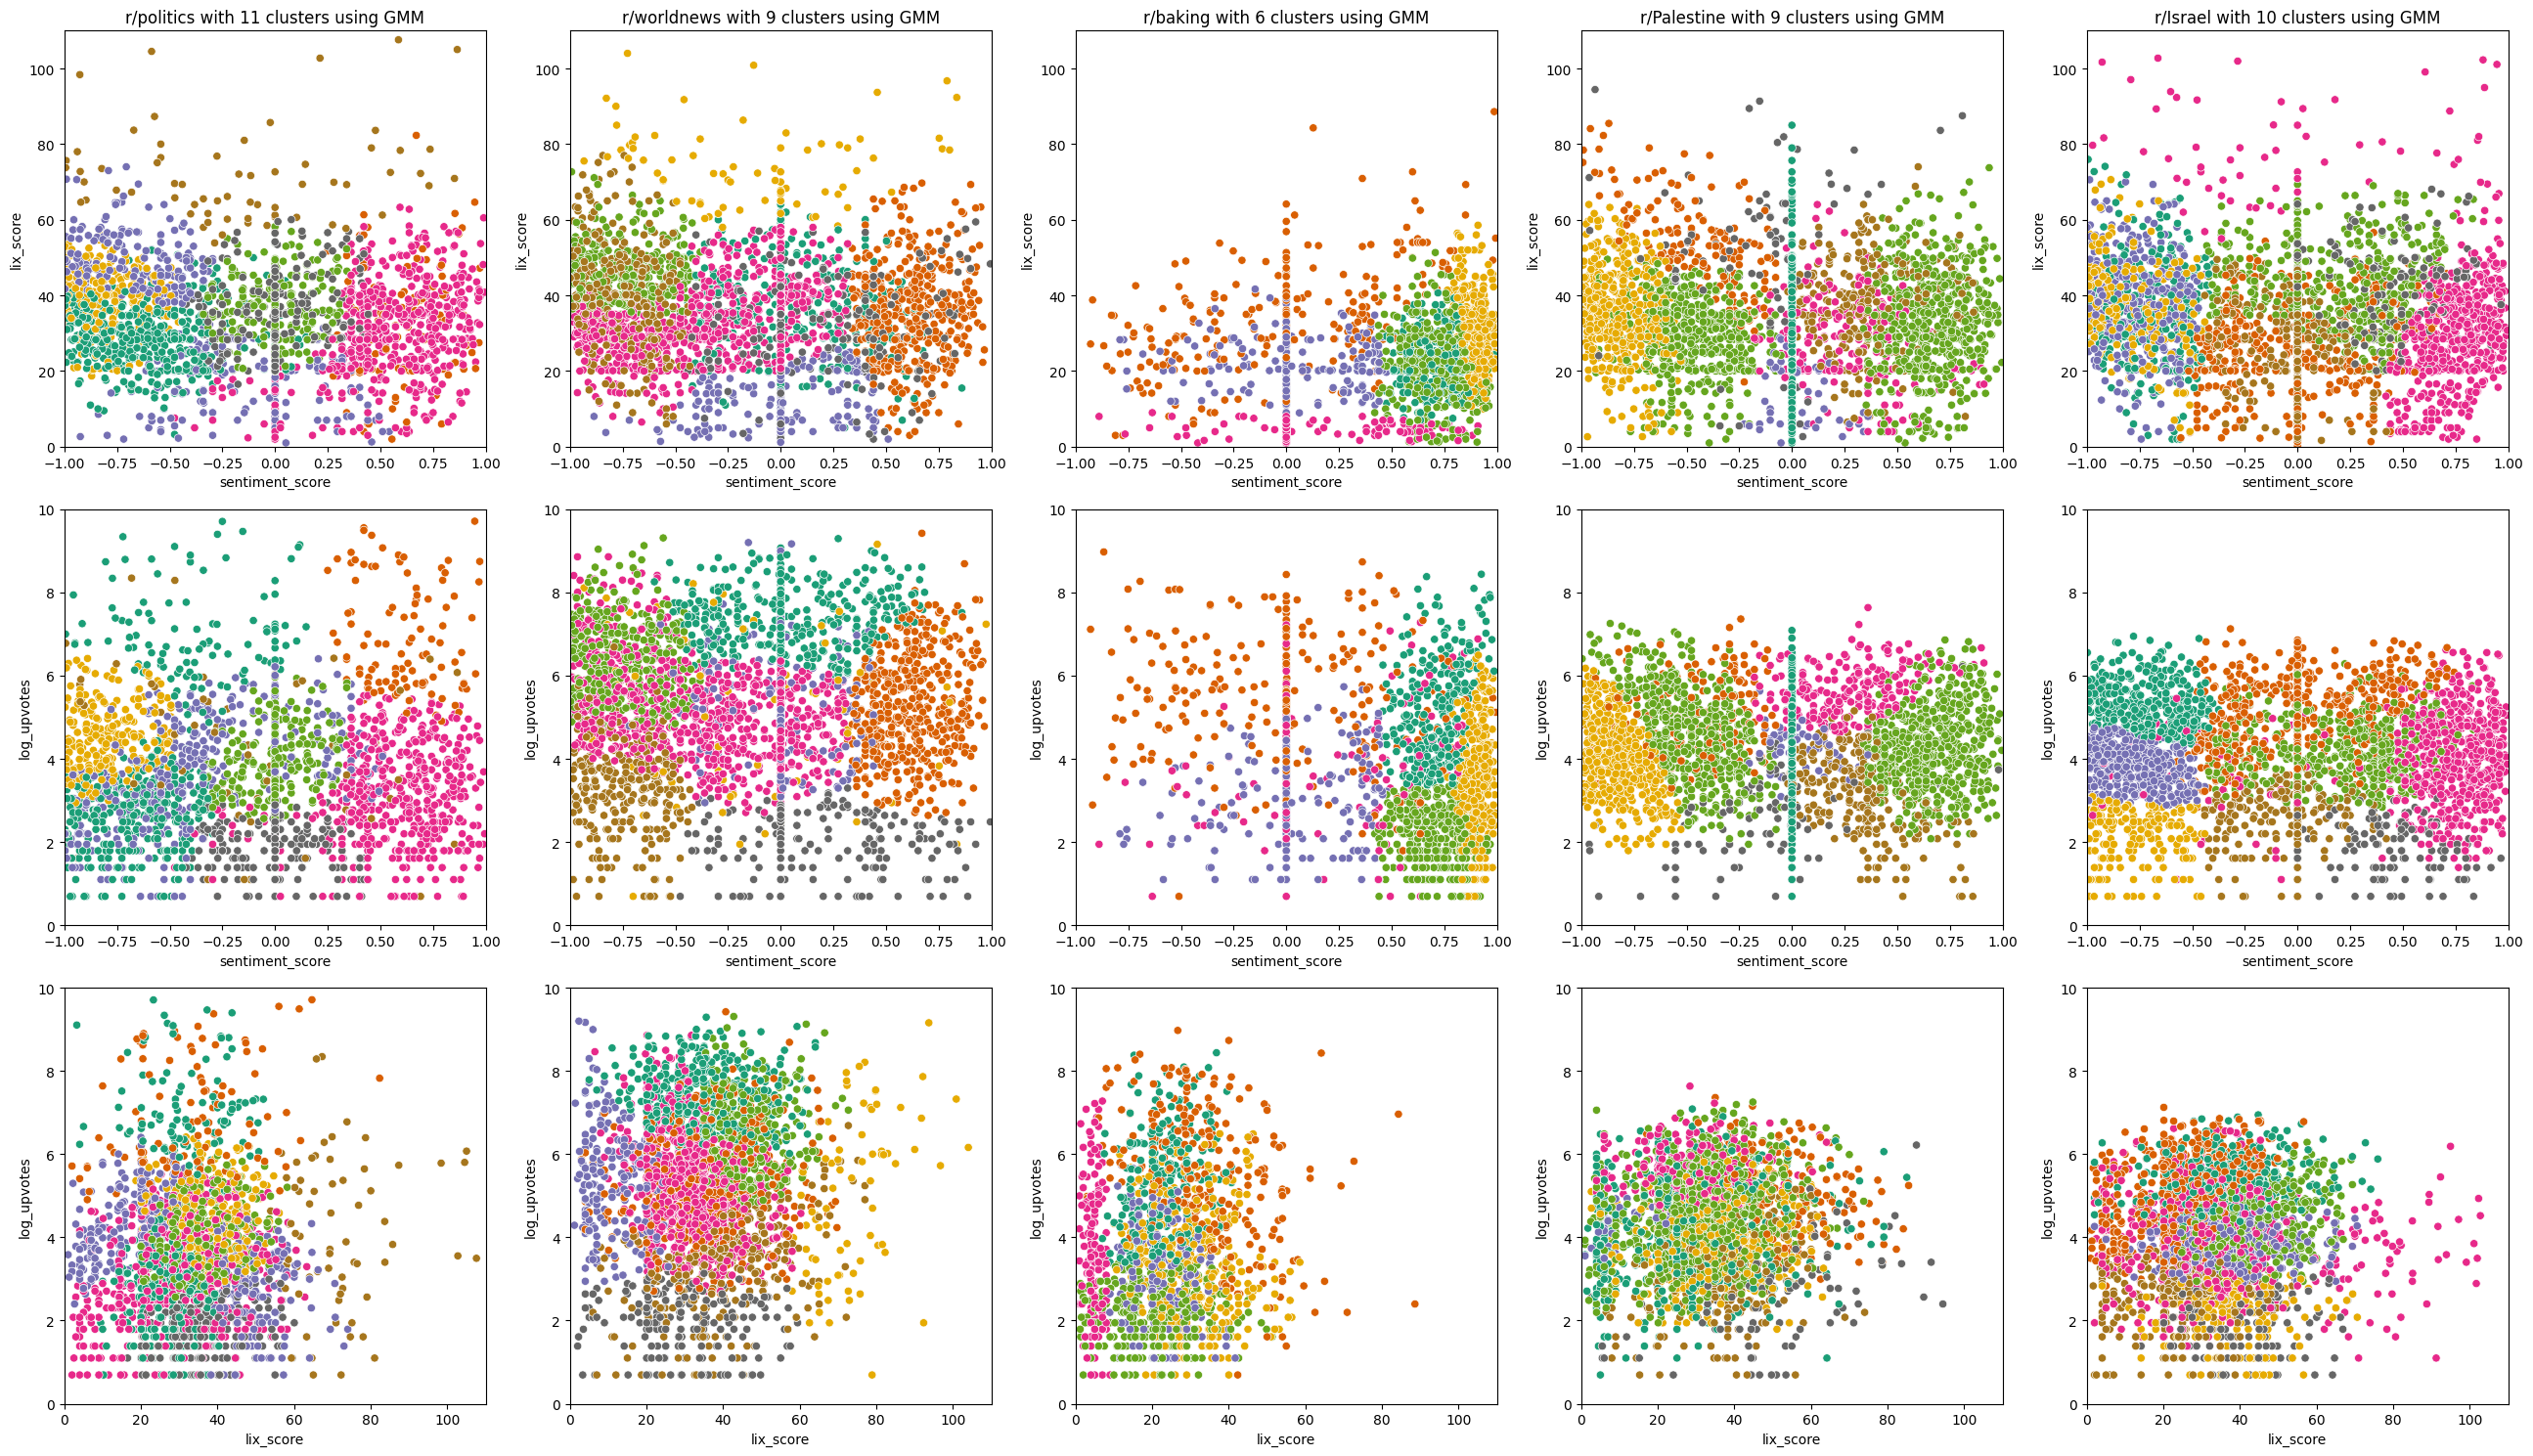

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=n_subs, figsize=(26, 15))

lix_lim = [0, 110]
sentiment_lim = [-1, 1]
log_upvotes_lim = [0, 10]

method = 'GMM' # Can also be 'DBSCAN'
cluster_type = f'{method}_cluster'

for i, (sub, df) in enumerate(dfs_clustered.items()):
    n_clusters = df[cluster_type].nunique()

    # Set color: grey for cluster -1, others will use a colormap
    colors = df[cluster_type].apply(lambda x: 'grey' if x == -1 else None)
    alphas = df[cluster_type].apply(lambda x: 0.1 if x == -1 else 1.0)
    
    # Handle valid colors for other clusters
    cmap = plt.get_cmap('Dark2', n_clusters)
    cluster_colors = df[cluster_type].apply(lambda x: cmap(x) if x != -1 else 'grey')

    # Plot the 2D scatterplots
    sns.scatterplot(ax=axes[0, i], data=df, x="sentiment_score", y="lix_score", hue=cluster_colors, palette='Dark2', legend=False, alpha=alphas)
    sns.scatterplot(ax=axes[1, i], data=df, x="sentiment_score", y="log_upvotes", hue=cluster_colors, palette='Dark2', legend=False, alpha=alphas)
    sns.scatterplot(ax=axes[2, i], data=df, x="lix_score", y="log_upvotes", hue=cluster_colors, palette='Dark2', legend=False, alpha=alphas)

    # Set axes limits
    axes[0, i].set_ylim(lix_lim)
    axes[0, i].set_xlim(sentiment_lim)
    axes[1, i].set_xlim(sentiment_lim)
    axes[1, i].set_ylim(log_upvotes_lim)
    axes[2, i].set_xlim(lix_lim)
    axes[2, i].set_ylim(log_upvotes_lim)

    axes[0, i].set_title(f'r/{sub} with {n_clusters} clusters using GMM')

plt.tight_layout()
plt.show()


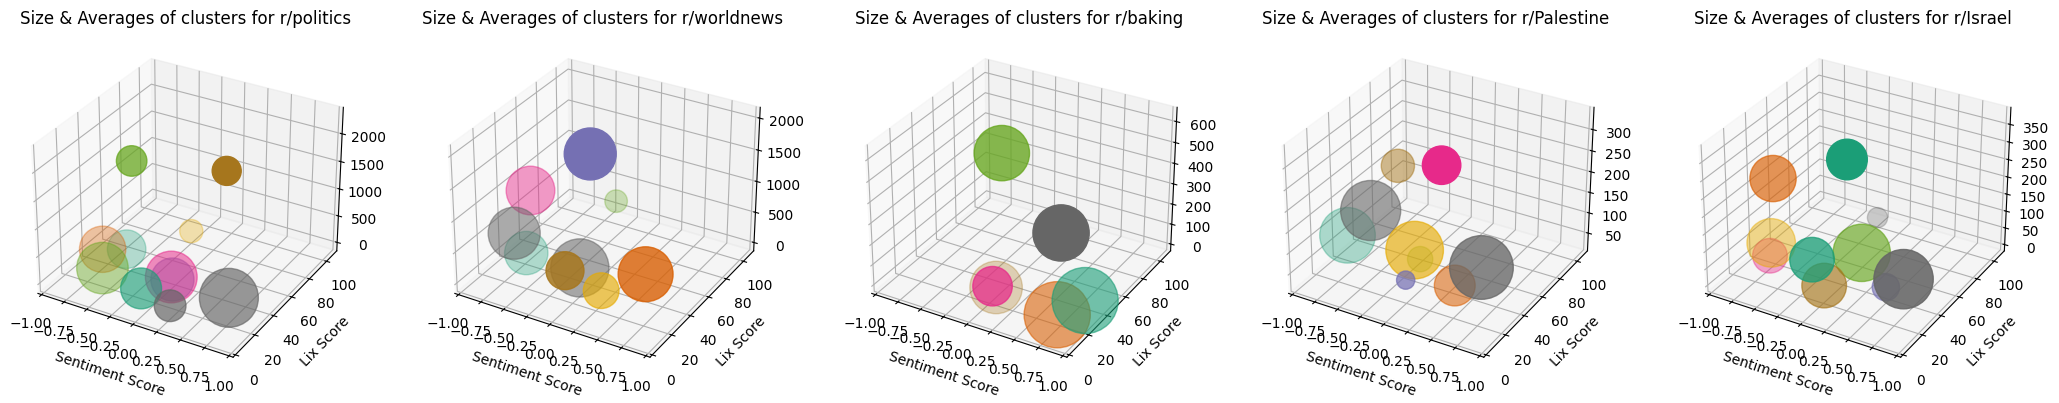

In [16]:
cluster_stats = {}

method = 'GMM' #Can also be 'DBSCAN'
cluster_type = f'{method}_cluster'


for sub, df in dfs_clustered.items():
    cluster_stats[sub] = pd.DataFrame(columns=['sub', 'cluster', 'observations', 'percentage', 'avg_upvotes', 'avg_lix_score', 'avg_sentiment_score', 'upvotes_std', 'lix_score_std', 'sentiment_score_std'])
    total_observations = len(df)
    for cluster in df[cluster_type].unique():
        cluster_df = df[df[cluster_type] == cluster]
        cluster_observations = len(cluster_df)
        percentage = cluster_observations / total_observations
        avg_upvotes = cluster_df['upvotes'].mean()
        avg_lix_score = cluster_df['lix_score'].mean()
        avg_sentiment_score = cluster_df['sentiment_score'].mean()
        opvotes_std = cluster_df['upvotes'].std()
        lix_score_std = cluster_df['lix_score'].std()
        sentiment_score_std = cluster_df['sentiment_score'].std()
        
        cluster_stats[sub].loc[cluster] = {
            'sub': sub,
            'cluster': cluster,
            'observations': cluster_observations,
            'percentage': percentage,
            'avg_upvotes': avg_upvotes,
            'avg_lix_score': avg_lix_score,
            'avg_sentiment_score': avg_sentiment_score,
            'upvotes_std': opvotes_std,
            'lix_score_std': lix_score_std,
            'sentiment_score_std': sentiment_score_std
        }

fig, axes = plt.subplots(nrows = 1, ncols = n_subs, figsize=(26, 5), subplot_kw={'projection':'3d'})
lix_lim = [0, 110]
sentiment_lim = [-1, 1]

for i, (sub, df) in enumerate(cluster_stats.items()):
    n_clusters = df.shape[0]
    # #Plot the 3d scatterplot
    axes[i].scatter(df['avg_sentiment_score'], df['avg_lix_score'], df['avg_upvotes'], facecolors='none', c = df['cluster'], cmap = 'Dark2', s = df['percentage']*100*100)
    axes[i].set_title(f'Size & Averages of clusters for r/{sub}')
    axes[i].set_xlabel('Sentiment Score')
    axes[i].set_ylabel('Lix Score')
    axes[i].set_ylim(lix_lim)
    axes[i].set_xlim(sentiment_lim)

In [22]:
cluster_stats


{'politics':          sub  cluster  observations  percentage  avg_upvotes  avg_lix_score  \
 6   politics        6           114    0.048264  2016.307018      32.558470   
 8   politics        8           103    0.043607  2301.097087      32.737241   
 0   politics        0           205    0.086791   116.536585      16.331347   
 10  politics       10           425    0.179932    46.555294      34.017875   
 4   politics        4           328    0.138865    69.240854      35.401896   
 2   politics        2           263    0.111346   121.923954      38.501727   
 7   politics        7            66    0.027942   262.651515      71.175782   
 5   politics        5           325    0.137595    18.387692      27.251196   
 1   politics        1           182    0.077053    21.197802      49.432136   
 9   politics        9           123    0.052075     9.162602      14.482811   
 3   politics        3           228    0.096528     6.868421      36.354946   
 
     avg_sentiment_score  

In [23]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Combine all DataFrames into one, adding a 'sub' column
combined_df = pd.concat(
    [df.assign(sub=subreddit) for subreddit, df in cluster_stats.items()], ignore_index=True
)

# Ensure 'sub' is a string
combined_df['sub'] = combined_df['sub'].astype(str)

# Columns to use for PCA
columns_to_use = [
    'avg_upvotes', 'avg_lix_score', 'avg_sentiment_score', 
    'upvotes_std', 'lix_score_std', 'sentiment_score_std'
]

# Ensure all columns are numeric
for col in columns_to_use:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

# Handle missing values (fill with 0 or drop rows with NaNs)
combined_df[columns_to_use] = combined_df[columns_to_use].fillna(0)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_df[columns_to_use])

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Add PCA results to the DataFrame
combined_df['PC1'] = pca_result[:, 0]
combined_df['PC2'] = pca_result[:, 1]

# Group by subreddit and compute the mean of PCA components
pca_summary = combined_df.groupby('sub', as_index=False)[['PC1', 'PC2']].mean()

# Display PCA summary
print("PCA Summary by Subreddit:")
print(pca_summary)


PCA Summary by Subreddit:
         sub       PC1       PC2
0     Israel -0.072014 -0.732231
1  Palestine -0.295334 -0.481663
2     baking -0.862072  0.606807
3   politics  0.184553  0.416740
4  worldnews  0.724499  0.381366


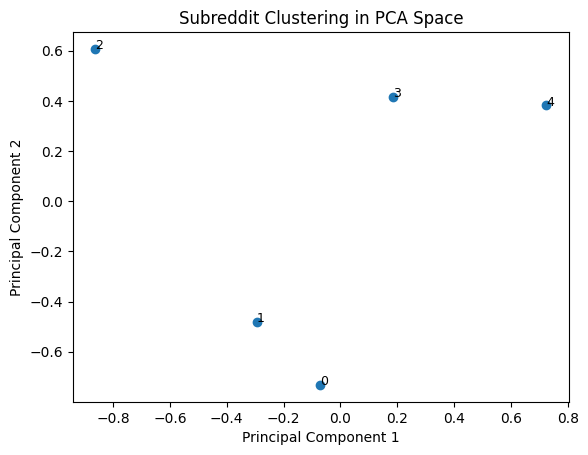

In [24]:
import matplotlib.pyplot as plt

# Scatter plot for PCA results
plt.scatter(pca_summary['PC1'], pca_summary['PC2'])
for subreddit in pca_summary.index:
    plt.text(pca_summary.loc[subreddit, 'PC1'], pca_summary.loc[subreddit, 'PC2'], subreddit, fontsize=9)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Subreddit Clustering in PCA Space')
plt.show()



David-Bouldin Index and Silhouette Score are two popular metrics for evaluating clustering quality. Here's a comparison of their pros and cons:

David-Bouldin Index
Pros:

Simplicity: It uses the ratio of intra-cluster distances to inter-cluster distances, making it intuitive to understand and compute.
Low Computation Overhead: It computes cluster compactness and separation without requiring pairwise comparisons for all points, which makes it computationally efficient for large datasets.
Focus on Cluster Separation: It directly penalizes poor separation and high intra-cluster variance, providing insights into cluster distinctness.
Cons:

Symmetry Assumption: It assumes clusters are roughly spherical and similar in size, which might not hold for irregular or highly variable clusters.
Dependent on Number of Clusters: It tends to favor solutions with a higher number of clusters, which might not align with the true structure.
Sensitive to Outliers: Outliers can inflate the intra-cluster distance, leading to a less reliable index.
Silhouette Score
Pros:

Comprehensive Assessment: It evaluates both cohesion (how similar a point is to its cluster) and separation (how different it is from other clusters).
Visualization: Offers a graphical representation (Silhouette plot) to understand the quality of clustering and to identify outliers or poorly assigned points.
Cluster Shape Flexibility: Performs well with clusters of varying shapes and densities.
Cons:

Computational Cost: It requires pairwise distance computation, making it expensive for large datasets.
Lack of Focus on Compactness: Does not directly assess intra-cluster compactness; clusters with widely spread points might still have high silhouette scores.
Interpretation Variability: A higher silhouette score might not always indicate better clustering in datasets with noise or overlaps.
When to Use Each?
David-Bouldin Index: Preferable when computational efficiency is a priority or when clusters are roughly spherical and well-separated.
Silhouette Score: Better for deeper analysis of clustering quality, especially when cluster shapes or densities vary or when visual diagnostics are needed.
Both metrics provide complementary insights, and using them together can offer a more comprehensive clustering evaluation.



Du sagde:
How do i determine in normalization is better than standardization, when normalization naturally produceses tighter results, so i cannot compare them using neither David-bouldin index or silhuette score
ChatGPT sagde:
When normalization (scaling data to a [0, 1] range) and standardization (scaling data to have a mean of 0 and standard deviation of 1) yield inherently different distributions that can't be compared using David-Bouldin Index or Silhouette Score, you can use the following approaches to decide which is better:

1. Understand the Dataset Characteristics
Normalization is better suited for:
Data with features that have different units or ranges but are positively bounded (e.g., age in years, income in dollars).
Methods like k-means clustering or distance-based algorithms that are sensitive to feature magnitudes.
Standardization is better for:
Data with normally distributed features or algorithms assuming Gaussian distributions (e.g., PCA, linear regression).
Features with outliers that could skew normalization.
2. Model-Specific Evaluation
Perform clustering or modeling separately on normalized and standardized datasets.
Evaluate the downstream performance (classification accuracy, cluster purity, regression error, etc.) rather than focusing solely on cluster separation scores.
3. Compare Consistency Across Methods
Use clustering algorithms less sensitive to scaling (e.g., DBSCAN) and compare cluster assignments from normalized and standardized datasets. Consistent results across both might indicate scaling doesn't matter.
4. Alternative Metrics
Consider using Adjusted Rand Index (ARI) or Mutual Information (MI) to compare cluster assignments against a known ground truth.
Use Calinski-Harabasz Index, which accounts for compactness and separation in clustering, but without the same sensitivity to scaling as DB or Silhouette.
5. Domain Knowledge
Reflect on the interpretability of features in your domain. For example:
Are absolute scales meaningful? If yes, prefer normalization.
Is understanding variance important? If yes, prefer standardization.
6. Visual Analysis
Plot feature distributions or pairwise feature relationships after normalization and standardization. Look for patterns such as:
Clusters or separations that appear natural and meaningful.
Reduction in skewness or alignment with the algorithm's assumptions.
Practical Workflow
Try both normalization and standardization.
Apply clustering or machine learning on each scaled dataset.
Evaluate downstream task performance, using metrics relevant to the problem.
Prefer the method that aligns better with both data characteristics and task-specific outcomes.
This balanced approach combines empirical performance and theoretical fit for deciding between normalization and standardization.



Du sagde:
Explain pros and cons of using david-bouins index vs. using silhuette vs. using Calinski–Harabasz
ChatGPT sagde:
The David-Bouldin Index, Silhouette Score, and Calinski–Harabasz Index are all cluster evaluation metrics, each with unique strengths and weaknesses. Here's a comparison:

David-Bouldin Index
Pros:

Focus on Compactness and Separation: Measures the ratio of intra-cluster distances to inter-cluster distances, directly evaluating cluster compactness and separation.
Low Computation Cost: Requires relatively simple calculations, making it efficient for large datasets.
Easy Interpretation: Lower values indicate better clustering, making it intuitive.
Cons:

Sensitivity to Outliers: Outliers inflate intra-cluster distances, skewing the index.
Assumption of Spherical Clusters: Assumes clusters are convex and evenly distributed, which might not hold for irregular clusters.
Bias Towards More Clusters: Tends to favor solutions with more clusters due to reduced intra-cluster distances.
Silhouette Score
Pros:

Point-Level Analysis: Evaluates how well each data point fits within its assigned cluster compared to other clusters, providing granular insights.
Handles Varying Cluster Shapes: Performs well even with irregular or non-spherical clusters.
Visual Insights: Can produce Silhouette plots to visually inspect clustering quality and outliers.
Cons:

High Computation Cost: Requires pairwise distance calculations for all points, which can be computationally expensive for large datasets.
Cluster Size Bias: May favor solutions where clusters are similar in size and density.
Relative Nature: Results depend on the dataset’s scale and distribution, making cross-dataset comparisons difficult.
Calinski–Harabasz Index
Pros:

Focus on Variance: Maximizes inter-cluster variance while minimizing intra-cluster variance, aligning with the clustering objective.
Speed: Relatively fast to compute because it relies on cluster centroids and variances.
Neutral on Cluster Shape: Less sensitive to assumptions about cluster shapes compared to David-Bouldin Index.
Cons:

Bias Towards More Clusters: Strongly favors higher numbers of clusters, as additional clusters reduce intra-cluster variance.
Assumption of Homogeneity: Assumes uniform distribution of points across clusters, which might not always apply.
Limited Interpretability: The magnitude of the index is harder to interpret compared to Silhouette Score or David-Bouldin Index.
When to Use Each Metric
David-Bouldin Index: Best for datasets with relatively spherical clusters and when computational efficiency is key.
Silhouette Score: Ideal for detailed analyses and irregular cluster shapes, or when a visual diagnostic is required.
Calinski–Harabasz Index: Good for comparing cluster counts in models and datasets where speed is critical but shapes may vary.
Summary Comparison Table
Metric	Focus	Pros	Cons	Best Use Case
David-Bouldin	Compactness/Separation	Simple, efficient, intuitive	Outlier-sensitive, shape-biased, favors many clusters	Convex, spherical clusters; quick evaluations
Silhouette	Point fit	Detailed, flexible with shapes, visual diagnostics	Computationally heavy, biased by size/density	Irregular clusters; when outlier analysis is key
Calinski–Harabasz	Variance-based	Fast, shape-neutral	Favors more clusters, harder to interpret	Comparing cluster counts; quick large-scale tests
Each metric has its strengths depending on the problem characteristics and computational constraints, so it's often beneficial to use them together for a comprehensive evaluation.



Du sagde:

My data looks like this. What does that indicate about which evaluation metric i should use?
ChatGPT sagde:
Looking at the visualizations of your data:

Feature Distributions:

The upvotes feature is highly skewed with many low values and a few high ones.
The sentiment_score is relatively evenly distributed but appears concentrated around 0.
The lix_score (likely readability or complexity metric) is also skewed, with a heavy tail.
Pairwise Relationships:

Scatterplots show non-linear relationships between features.
There is significant clustering along certain axes, indicating outliers or possible data imbalances.
Contours:

The contours reflect non-uniform distributions, particularly for upvotes vs. other features, suggesting clusters of varying densities.
Implications for Metric Choice
David-Bouldin Index:

Likely inappropriate for this dataset because it assumes spherical and well-separated clusters, while your data seems non-spherical and has high variance in density.
Sensitive to the skew in upvotes and lix_score.
Silhouette Score:

A better choice for irregular or non-spherical clusters.
However, the high skew in upvotes might influence the distances, so ensure scaling is applied (e.g., standardization or normalization).
Calinski–Harabasz Index:

Would work well if you apply proper scaling and your goal is to evaluate variance-based cluster separation. However, it may favor clustering solutions with more clusters due to the skew in features.
Recommendation
Given the skewed and irregular distribution:

Start with Silhouette Score after scaling the data to handle skew and ensure equal weighting of features.
If computational efficiency is critical or you're exploring cluster counts, use the Calinski–Harabasz Index with scaled data.
Avoid the David-Bouldin Index unless your clustering algorithm ensures near-spherical clusters or you transform the data to better meet its assumptions.
You can also combine metrics for more comprehensive evaluation.



Du sagde:

Based on this, does it seem better to normalize or standardize the data?
ChatGPT sagde:
Based on the provided visualization of your data, here is an analysis to determine whether normalization or standardization is more appropriate:

Feature Analysis
Upvotes:

Highly skewed with a heavy tail.
Requires transformation to reduce skewness, possibly logarithmic scaling, before applying normalization or standardization.
Sentiment Score:

Centered around 0 with a relatively symmetric distribution.
Standardization would work well for this feature since it aligns with the Gaussian-like assumption.
Lix Score:

Positively skewed with values concentrated in the lower range.
Like upvotes, may benefit from a transformation before scaling.
Scaling Options
Normalization (Scaling to [0, 1]):

Good for features with different ranges, particularly if you're using distance-based methods like k-means.
However, upvotes and lix_score are heavily skewed, so normalization might compress most of the data into a small range and amplify the influence of outliers.
Conclusion: Not ideal without addressing skewness first.
Standardization (Mean = 0, Std. Dev = 1):

Handles skewness better, especially if coupled with transformations (e.g., logarithmic for upvotes and lix_score).
Ensures features are on comparable scales, crucial for algorithms sensitive to feature variance (e.g., PCA, SVM).
Conclusion: Likely better for this dataset if transformations are applied to address skewness.
Recommendation
Standardize the data, but first apply:

Log or Power Transform: For upvotes and lix_score to reduce skewness.
No Transformation for Sentiment Score: It appears symmetric and centered, making it ready for standardization.
After transformations, use standardization to ensure all features have a mean of 0 and standard deviation of 1, which aligns better with most machine learning and clustering algorithms.

This approach balances skewness reduction and ensures features are appropriately scaled for clustering or other machine learning methods.



Du sagde:

Given that my data looks like this and i want to perform clustering, would it be better to normalize or standardize the data? I am going to apply a log-transformation to upvotes
ChatGPT sagde:
Given that you plan to apply a log-transformation to the upvotes feature and want to perform clustering, the decision between normalization and standardization depends on your clustering algorithm and the characteristics of your dataset. Here's the analysis:

Log-Transformation on Upvotes
This will reduce the skew of the upvotes feature, making it more normally distributed.
After this transformation, the scale of upvotes will still differ significantly from the other features unless scaling is applied.
Normalization
When it works well:

For distance-based algorithms like k-means or DBSCAN, normalization ensures all features contribute equally to distance calculations by rescaling them to a uniform range (e.g., [0, 1]).
If all features have different ranges or magnitudes (like in your dataset), normalization prevents dominant features from overpowering smaller ones.
Particularly effective if cluster sizes and densities are expected to vary across a uniform scale.
Potential downside:

If the distributions of features are very different (e.g., sentiment_score is centered around 0, while lix_score is heavily skewed), normalization alone won't account for shape differences across features.
Standardization
When it works well:

If clustering algorithms rely on variance (e.g., Gaussian Mixture Models, hierarchical clustering) or assume normally distributed data.
Standardization brings all features to the same scale (mean = 0, std dev = 1), making it robust to outliers compared to normalization.
Works better when distributions are approximately normal (which will be closer to true for upvotes after log-transformation).
Potential downside:

For highly skewed features like lix_score, standardization may not fully mitigate the impact of outliers, and additional transformation might be necessary.
Recommendation for Your Data
Step 1: Log-transform upvotes to reduce skew.

Step 2: Apply Standardization:

Since your sentiment_score is already centered and lix_score is skewed, standardization will normalize feature variances, ensuring equal contribution to clustering.
Standardization also aligns well with clustering methods sensitive to feature variance, like Gaussian Mixture Models or hierarchical clustering.
Consider Normalization Only If:

You use distance-based clustering (e.g., k-means) and the shapes of the feature distributions become comparable after transformations.
Final Note
If your clustering algorithm depends heavily on distance, normalization might perform better after the log-transformation. However, if your algorithm involves assumptions about variance or Gaussian distributions, standardization would be the optimal choice. You can try both approaches and evaluate clustering results using metrics like Silhouette Score or Calinski-Harabasz Index to confirm the best choice.



Du sagde:

Does it make a lot of sense that a GMM model has a significantly better silhuette index?
ChatGPT sagde:
It is unusual for a Gaussian Mixture Model (GMM) to have a significantly better Silhouette Score compared to clustering methods like k-means or hierarchical clustering, especially if the data does not inherently follow a Gaussian distribution. Here’s why:

How Silhouette Score Works
Measures how well-separated clusters are by comparing:
Cohesion: How close each point is to others in its own cluster.
Separation: How far each point is from points in other clusters.
Values range from -1 (poor clustering) to 1 (good clustering).
Why GMM Often Scores Lower
Cluster Overlap:

GMM allows soft assignments (probabilities), meaning a point can belong to multiple clusters. Silhouette, however, assumes hard clustering (a single label per point).
This mismatch can lead to lower cohesion or separation in the Silhouette Score.
Cluster Shapes:

Silhouette Score implicitly favors compact, well-separated clusters (as produced by k-means or hierarchical clustering).
GMM can produce overlapping or elongated clusters, reducing the perceived "tightness."
When GMM Might Score Higher
True Gaussian Structure:

If your data naturally forms Gaussian-shaped clusters, GMM aligns better with the underlying structure and can outperform k-means or hierarchical clustering.
Standardization:

Standardization (as in your data) helps Gaussian models perform better because it eliminates scale differences, which Gaussian models are sensitive to.
Cluster Distribution:

If clusters have varying densities or shapes, GMM can adapt better than k-means, leading to improved cohesion and separation.
What to Investigate
Data Characteristics:

Does your data align with Gaussian distributions? If not, GMM’s higher score might indicate overfitting or a mismatch between the evaluation metric and clustering approach.
Soft Assignment Influence:

Analyze how GMM is assigning probabilities. If most points have high probabilities for a single cluster, the result may behave similarly to hard clustering, inflating the Silhouette Score.
Cluster Validation Metrics:

Use additional metrics (e.g., Calinski-Harabasz Index or Davies-Bouldin Index) to confirm whether GMM truly performs better or if Silhouette Score is being misled by peculiarities of the data.
Conclusion
While it’s not impossible for GMM to score higher, it’s worth scrutinizing the nature of the data and how clusters are formed. If your data isn’t Gaussian-like, or if GMM heavily overlaps clusters, the higher Silhouette Score might not reflect true clustering quality. Additional evaluation metrics can help clarify whether GMM is genuinely outperforming or if the metric is favoring it due to data-specific quirks.